# Dataset 
> Functions for dataset

In [ ]:
# default_exp dataset
# default_cls_lvl 2

## Dataset Basics

In this notebook we are going to define the dataset for our Horse Poo Detector. I do the labeling with [prodi.gy](https://prodi.gy/). From there the data is exported as JSONL [JSON-lines](http://jsonlines.org/). The picture itself is encoded in a base64-URL format. The easiest way is to extract the pictures to a folder and then use the libraries given.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import json
import nbdev
import re
import base64
import PIL
import pathlib
import torch
import jsonlines
from torch.utils.data import Dataset, DataLoader
from io import BytesIO
from fastai.vision import *

In [ ]:
#export
def read_jsonl(file_path):
    """returns a generator which returns each jsonl line.
    """
    with pathlib.Path(file_path).open('r', encoding='utf8') as f:
        for line in f:
            try:  # hack to handle broken jsonl
                str_json = json.loads(line)
                if str_json['answer'] == 'accept':
                    yield str_json
            except ValueError:
                continue

In [ ]:
show_doc(read_jsonl)

<h4 id="read_jsonl" class="doc_header"><code>read_jsonl</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>read_jsonl</code>(**`file_path`**)

returns a generator which returns each jsonl line.
    

In [ ]:
rj = read_jsonl('test_data/sample.jsonl')
data_point = next(rj)
assert 'image' in data_point, 'image key expected'
assert 'width' in data_point, 'width key expected'
assert 'height' in data_point, 'height key expected'
assert 'spans' in data_point, 'spans key expected'

In [ ]:
#export
def base64ToImage(base64_string):
    """ convert base64 string to image"""
    base64_string = base64_string[23:]
    imgdata = base64.b64decode(str(base64_string))
    image = PIL.Image.open(io.BytesIO(imgdata))
    #image = np.rollaxis(np.array(image), 2, 0)
    #image = pil2tensor(image,np.float32)
    #image.div_(255)
    #image = Image(image)
    return image

In [ ]:
show_doc(base64ToImage)

<h4 id="base64ToImage" class="doc_header"><code>base64ToImage</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>base64ToImage</code>(**`base64_string`**)

convert base64 string to image

In [ ]:
#export
def add_padding(image:PIL.Image, target_size=640):
    """this function adds padding so we have a rectangulare shape"""
    delta_w = target_size - image.size[0]
    delta_h = target_size - image.size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    new_im = PIL.ImageOps.expand(image, padding)
    return new_im

In [ ]:
show_doc(add_padding)

<h4 id="add_padding" class="doc_header"><code>add_padding</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>add_padding</code>(**`image`**:`PIL.Image`, **`target_size`**=*`640`*)

this function adds padding so we have a rectangulare shape

In [ ]:
rj = read_jsonl('test_data/sample.jsonl')
data_point = next(rj)
image = base64ToImage(data_point['image'])

before = image.size
image = add_padding(image)
after = image.size
assert before != after
assert after[0] == after[1]
assert before[0] == after[0]

In [ ]:
rj = read_jsonl('test_data/sample.jsonl')
data_point = next(rj)
image = base64ToImage(data_point['image'])
assert type(image) == PIL.JpegImagePlugin.JpegImageFile
assert image.size == (640, 352)

In [ ]:
#export 
def span_to_box(jsonl:str, adjust_for_padding=0):
    """converts span data to list with points and labels"""
    box_points = []
    labels = []
    for box in jsonl['spans']:            
        x1 = np.array(box['points'])[:,1].min() + adjust_for_padding   
        x2 = np.array(box['points'])[:,1].max() + adjust_for_padding
        y1 = np.array(box['points'])[:,0].min() 
        y2 = np.array(box['points'])[:,0].max() 
        box_points.append([x1,y1,x2,y2])            
        labels.append(box['label'])
    return [box_points, labels]

In [ ]:
rj = read_jsonl('test_data/sample.jsonl')
data_point = next(rj)
boxes = span_to_box(data_point)

assert len(boxes) == 2
assert len(boxes[0][0]) == 4
assert len(boxes[1]) == 1


boxes_with_padding = span_to_box(data_point, adjust_for_padding=100)
assert boxes[0][0][0] + 100 == boxes_with_padding[0][0][0]
assert boxes[0][0][2] + 100 == boxes_with_padding[0][0][2]



In [ ]:
#export
def jsonl_convert(path:Path, add_pad=True):
    """convert jsonl to folder  with image files for better handling"""
    if type(path) == str:
        path = Path(path)
    path_target_fld = (path.parent / path.stem)
    path_target_fld.mkdir(parents=True, exist_ok=True)
    boxes = dict()
    for jsonl in read_jsonl(str(path)):
        base64_string = jsonl['image']
        base64_string = base64_string[23:]
        imgdata = base64.b64decode(str(base64_string))
        image = PIL.Image.open(io.BytesIO(imgdata))
        image_size = image.size
        if add_pad: 
            image = add_padding(image)
        image.save(str(path_target_fld / jsonl['meta']['file']))
        
        adjustment = (image_size[0] - image_size[1])/2
        boxes[jsonl['meta']['file']] = span_to_box(jsonl, adjust_for_padding=adjustment)
    
    with open(path_target_fld / 'boxes.json', 'w') as fp:
        json.dump(boxes, fp)
        
    return boxes
        

In [ ]:
#hide 

# delete folder and content
import os, shutil


folder = 'test_data/sample/'
if os.path.isdir(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
                shutil.rmtree(file_path)

    shutil.rmtree(folder)
   

In [ ]:
boxes = jsonl_convert('test_data/sample.jsonl')

assert os.path.isfile(str(Path(folder) / '20190607060607_784617.jpg'))
assert len(os.listdir(folder)) == 5


In [ ]:
boxes

{'20190607060607_784617.jpg': [[[235.1, 393.4, 350.7, 466.7]], ['FABI']],
 '20190604163231_494665.jpg': [[[230.9, 501.0, 333.0, 639.5]], ['FABI_POO']],
 '20181216093008.jpg': [[[232.9, 204.7, 415.9, 481.8]], ['FABI_POO']],
 '20190602194351.jpg': [[[174.3, 172.4, 289.6, 303.8],
   [306.8, 61.2, 399.8, 218.9]],
  ['FABI', 'SOPHIE']]}

In [ ]:
#export 
def get_labels_for_folder(folder:Path):
    """reads labels from boxes.json file"""
    if type(folder) is str:
        folder = Path(folder)
    with open(str(folder / 'boxes.json'), 'r') as fp:
        data = json.load(fp)
    return data
        

In [ ]:
folder = Path('test_data/sample')
file = Path('test_data/sample.jsonl')
jsonl_convert(file)
boxes = get_labels_for_folder(folder)

assert len(boxes) == 4
assert '20190607060607_784617.jpg' in boxes.keys()

In [ ]:
folder = 'test_data/sample/' 
boxes = get_labels_for_folder(folder)
transforms = get_transforms(
    do_flip=True, flip_vert=False, 
    max_rotate=None, max_zoom=1, 
    max_lighting=0.2, max_warp=None, 
    p_affine=0.75, p_lighting=0.75)
transforms
#transforms = [[brightness(change=(0.4, 0.6), p=0.75), contrast(scale=(0.8, 1.25), p=.75)],[]]

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

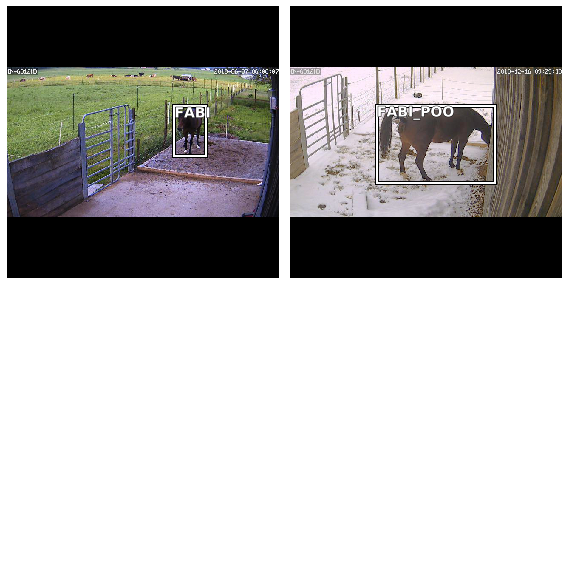

In [ ]:
data = (ObjectItemList
        .from_folder(folder)
        .split_by_rand_pct(0.5)
        .label_from_func(lambda o: boxes[o.name])
        .transform(transforms, tfm_y=True)
        .databunch(bs=2, collate_fn=bb_pad_collate)
       # .normalize(imagenet_stats)
       )

data.show_batch()

## Transforms
In our usecase it only makes sense to flip the picture horizontal. We will use fastai's functions as much as possible.

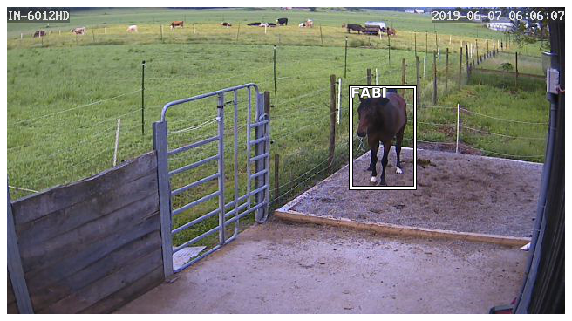

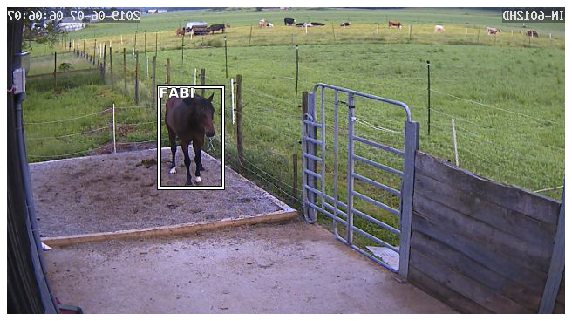

In [ ]:
rj = read_jsonl('test_data/sample.jsonl')
jsonl_string = next(rj)
(image, box) = image_with_box_from_json(jsonl_string)



image.show(figsize=(10,10), y=box)
box = box.flip_lr()
image = image.flip_lr()

image.show(figsize=(10,10), y=box)

In [ ]:
def transforms_with_bbox(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10., max_zoom:float=1.1,
                   max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75,
                   p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None)->Collection[Transform]:
    "Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms."
    res = [rand_crop()]
    
    if do_flip:    
        TfmPixel
        res.append(dihedral_affine() if flip_vert else flip_lr(p=0.5))
    if max_warp:   res.append(symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine))
    if max_rotate: res.append(rotate(degrees=(-max_rotate,max_rotate), p=p_affine))
    if max_zoom>1: res.append(rand_zoom(scale=(1.,max_zoom), p=p_affine))
    if max_lighting:
        res.append(brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting))
        res.append(contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting))
    #       train                   , valid
    return (res + listify(xtra_tfms), [crop_pad()])

In [ ]:
#export
def get_rand_transformed_image(image:Image, bbox:ImageBBox, transforms:list):
    """returns a random transformed image"""
    for transform in transforms:
        print(type(transform))
    return image, bbox


In [ ]:
rj = read_jsonl('test_data/sample.jsonl')
jsonl_string = next(rj)

def get_class_ex(): 
    (image, box) = image_with_box_from_json(jsonl_string)
    return image


def get_bb_ex():
    (image, box) = image_with_box_from_json(jsonl_string)
    return image, box


image, box = get_bb_ex()

get_rand_transformed_image(image,box, transforms=[flip_lr(), brightness()])

<class 'fastai.vision.image.RandTransform'>
<class 'fastai.vision.image.RandTransform'>


(Image (3, 352, 640), ImageBBox (352, 640))

In [ ]:
rj = read_jsonl('test_data/sample.jsonl')
jsonl_string = next(rj)


image = resize_to(image, targ_sz=224)
print(image)


def get_class_ex(): 
    (image, box) = image_with_box_from_json(jsonl_string)
    return image


def get_bb_ex():
    (image, box) = image_with_box_from_json(jsonl_string)
    return image, box
  

In [ ]:
image = 
image = resize_to(image, targ_sz=224)
print(image)


In [ ]:
tfms = get_transforms()
tfms = [flip_lr(), brightness(), contrast()]
_, axs = plt.subplots(2,4,figsize=(12,6))

for ax in axs.flatten():
    image, box = get_bb_ex()
    img = image.apply_tfms([crop_pad()], image, size=(224))
    #box = box.apply_tfms(tfms[0], box, size=224)
    
    img.show(ax=ax)

AttributeError: 'tuple' object has no attribute 'show'

## Dataloader
In order to create a Databunch we need to have at least a train and validation data loader.

In [ ]:
def get_dataloader(
        path='data/interim/data.json',
        train_test_split=0.8,
        batch_size_train=5,
        batch_size_test=5,
        shuffle_train=True,
        perm_images=True,
        transform_train=True,
        transform_test=False,
        class_names=None):
    """ get the dataloader objects """

    # use our dataset and defined transformations
    if class_names is None:
        dataset = ProdigyDataset(path, transforms=[])
        dataset_test = ProdigyDataReader(path, get_transforms(train=transform_test))
    else:
        dataset = ProdigyDataReader(path, get_transforms(train=transform_train),
                                    object_categories=class_names)
        dataset_test = ProdigyDataReader(path, get_transforms(train=transform_test),
                                         object_categories=class_names)

    # split the dataset in train and test set
    if perm_images:
        indices = torch.randperm(len(dataset)).tolist()
    else:
        indices = list(range(len(dataset)))

    len_train = int(len(indices) * train_test_split)
    dataset = torch.utils.data.Subset(dataset, indices[:len_train])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[len_train:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size_train, shuffle=shuffle_train, num_workers=0,
        collate_fn=collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0,
        collate_fn=collate_fn)

    return [data_loader, data_loader_test]

## Data Reader Tests

In [ ]:
from nbdev.export import *
notebook2script()


Converted 00_dataset.ipynb.
Converted index.ipynb.
